# Transformer Architecture From Scratch

The aim of this project is to understand the Transformer architecture from a bare bones perspective. The code for projects like this are already freely available, so I won't be using any of those.

## Overall Architecture based on Attention Is All You Need

The basic architecture is from the paper, Attention Is All You Need. I will be searching online to see if there are any modifications/improvements to this architecture as I go through the code, so some parts might not be entirely accurate to the graph flow.

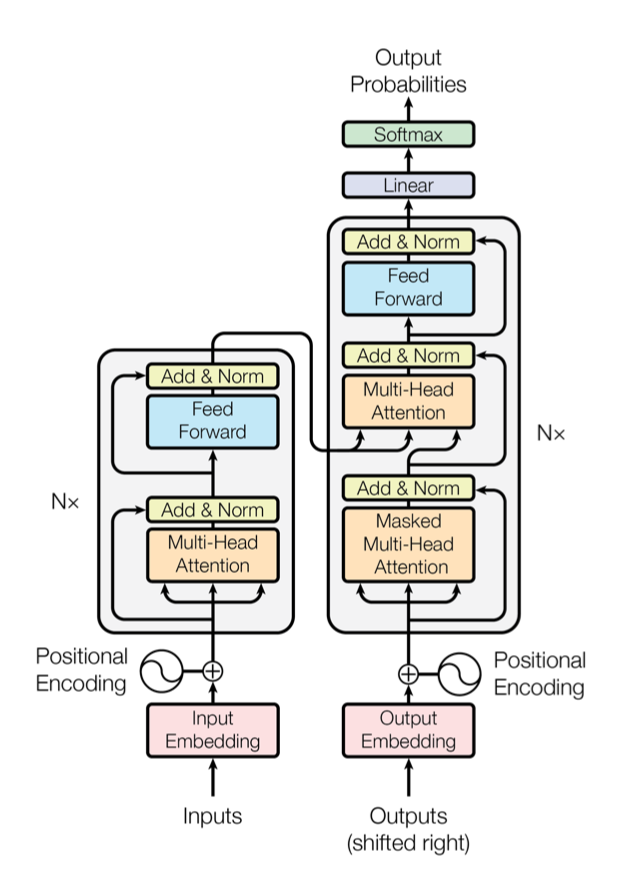



## What is the best place to start?
The best place to start understand would of course be with inputs! So where can we understand inputs?

### Inputs
Inputs for Transformer architectures come in the form of sequential data. Sequential data means we have information provided piece by piece, in the form of a sentence, audio, images (by specifying how to read the image).

Sequential data is important because we need to convert pieces into individual tokens.

Tokens are always (currently) integer representations of a character or segment of characters. We need to preprocess inputted text, segment into words, map words to tokens in your given vocabulary.

The vocabulary is a list of all unique tokens in a given set of words. The paper BERT uses one called WordPiece. this is a good starting point for a simple model, but can be swapped out for more optimised tokens depending on task specifications (i.e. financial documents, medical documents, etc.).

For our model we'll just start out with WordPiece and upgrade if necessary but I don't see that being something important.

#### Side-Tangent: WordPiece
Word piece makes tokens by breaking text down into characters and words. By doing this, our model is able to gain a good understanding of extraneous elements such as pluralisation and other elements for words.

    Because tokenization is not the main focus of this notebook, we'll follow the model from huggingface for the WordPiece tokenizer library

### Token Embedding
We need to pass input_ids through a pre-trained BERT embedding layer, which will return tokens as vectors of size d_model. The result of this will be a matrix of size (len(input_ids), d_model).

In [64]:
# Tokenization
from transformers import BertTokenizer, BertModel
import transformers
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def token_embedding(sentence):
    # Tokenize the sentence
    tokens = tokenizer(sentence, return_tensors='pt') # Returns tokens in pytorch format

    # Token Embedding (hidden states)
    with torch.no_grad(): # No gradients because we loaded an already trained model
        outputs = model(**tokens)
        
    # Outputs the last_hidden_state, and the pooler_output which is the [CLS] token for classification tasks
    last_hidden_state = outputs.last_hidden_state
    
    return tokens, last_hidden_state, outputs

We can test the tokenization with two sentences, one without any spelling errors, the other with a few errors.

In [102]:
#print(tokened("Hello, this is an example sentence."))
token, lhs, out = token_embedding("Hello this is an example sentence")
print(lhs.shape[2])

768


### Positional Enocoding

#### We would use this, however, we're using a pretrained BERT model so this isn't necessary. Although, I will keep this in because it is important to understand!

Positional encoding stores information about the location of the token or at least relative position in the sequence to help produce a likely outcome in a given order. We do this with sine and cosine functions with differing frequencies.
\begin{align}
PE_{(pos, 2i)} &= sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} &= cos(pos/10000^{2i/d_{model}})
\end{align}
pos is the position of token in the tokens, and i is the dimension. This i is calculated from the embedding dimension, if i is even use sine, if i is odd use cosine. The variable i will range from 0 to d_model - 1, it will fill in all those positions. This model size can be whatever our model will have.

In [58]:
import numpy as np

def pos_encoder(input_ids, d_model):
    n = len(input_ids)
    PE = np.zeros((n, d_model))
    for pos in range(n):
        for i in range(d_model):
            angle = pos / ( 10000 ** ((2 * i) / d_model) )
            PE[pos, 2 * i] = np.sin(angle)
            PE[pos, 2 * i + 1] = np.cos(angle)
    return PE

### Softmax
We'll tackle the Softmax function next so that we create the input modificaitons and output modifications. In this way, we'll understand the inputs and the desired outcome, therefore, the intermediary functions will have a clear design.

The Softmax function for the transformer model computes attention weights,
\begin{equation}
\text{Softmax}(x_i) = \frac{e^{x_{ij}}}{\sum_j e^{x_{ij}}}.
\end{equation}
In this equaiton, i represents the given index of the query token in the sequence, and j represents the index over all key tokens (otherwise the columns index).

The softmax function will also be necessary for the Attention mechanism later down the line. When we get to that we'll need to understand that it requires a masking matrix. We'll add dependencies for that in our code, but we'll understand what it is exactly later down the line.

    Given we're working with matrix operations, the best package to pick for the Softmax equation will be PyTorch!

We're transforming linearly for Queries, Keys, and Values. They need different linear layer transforms because they will potentially have different feature dimensions

    I know that torch has a softmax function, but the goal is to understand the tranformer architecture, not blindly let a framework give us an answer; ignoring the tokens though.

### Linear Transform
We'll also apply the linear transformation at the same time because it is fairly easy to implement. Some things to note about linear transforms is that they don't always have to change the model d_k and d_v to the same size. These values can be different depending on the flexibility of your model. For simplicity, we'll stick to the same values for ours.

In [46]:
import torch.nn as nn

# Define a linear layer to transform the tensor's Q, K, and V
linear_Q = nn.Linear(768, 512, bias=False) # 512 is the size of our model
linear_K = nn.Linear(768, 512, bias=False) # We set bias=False to not include a bias term in our linear transform
linear_V = nn.Linear(768, 512, bias=False)

# These values are defined differently because they are updated during backpropagation!

# Apply our linear transformation
Q = linear_Q(lhs)
K = linear_K(lhs)
V = linear_V(lhs)

# Compute attention scores for Softmax input QK^T/sqrt(d)
attention_scores = torch.bmm(Q, K.transpose(1, 2)) # .bmm is a batch matrix-matrix multiplication

# Divide attention scores by dimension scaling sqrt(d_k)
d_k = K.size(-1)
scaled_attention_scores = attention_scores / torch.sqrt(torch.tensor(d_k, dtype=attention_scores.dtype, device=attention_scores.device))

def softmax(attention_scores):
    # Compute exponentials
    exp_scores = torch.exp(attention_scores)
    
    # Summation over column elements
    sum_exp_scores = torch.sum(exp_scores, dim=-1, keepdim=True)

    # Normalise by dividing each exponentiated score by the sum
    softmax_output = exp_scores / sum_exp_scores

    return softmax_output

In [39]:
softmax_out = softmax(scaled_attention_scores)
print(softmax_out)

tensor([[[0.1208, 0.1109, 0.1393, 0.1280, 0.1325, 0.1394, 0.1161, 0.1131],
         [0.1320, 0.1211, 0.1330, 0.1229, 0.1280, 0.1287, 0.1298, 0.1045],
         [0.1415, 0.1239, 0.1146, 0.1235, 0.1274, 0.1454, 0.1246, 0.0991],
         [0.1361, 0.1308, 0.1199, 0.1211, 0.1265, 0.1373, 0.1277, 0.1007],
         [0.1256, 0.1336, 0.1116, 0.1221, 0.1258, 0.1449, 0.1309, 0.1055],
         [0.1266, 0.1330, 0.1146, 0.1277, 0.1346, 0.1254, 0.1326, 0.1055],
         [0.1273, 0.1338, 0.1262, 0.1165, 0.1269, 0.1311, 0.1212, 0.1170],
         [0.1343, 0.1386, 0.1183, 0.1040, 0.1157, 0.1407, 0.1212, 0.1273]]],
       grad_fn=<DivBackward0>)


### Add & Norm
This section creates the residual connection in the model and takes as input the output of the attention mechanism, as well as the output of the feed forward block. It will be a sum of the LayerOutput + Input. The block then normalises to stabilise the training process and build towards a final goal, or the convergence. This will normalise the output of the residual connection, the equation for the normalisation will be,
\begin{equation}
\hat{x} = \frac{x - \mu}{\sigma + \epsilon},
\end{equation}
where x is the input tensor, $\mu$ is the mean of the tensor's elements, $\sigma$ is the standard deviation of the tensor's elements, and $\epsilon$ is a small constant to avoid dividing by 0. We will be using torch.nn's normalise function.

In [93]:
def add_norm(tensor, other_tensor, size):
    # tensor: output of the previous block performed
    # other_tensor: output form the multi_head_attention block

    # Sum of layers
    tensor_sum = tensor + other_tensor
    
    # Normalisation
    a = nn.Parameter(torch.ones(size))
    b = nn.Parameter(torch.zeros(size))
    mean = tensor.mean(-1, keepdim=True)
    std = tensor.std(-1, keepdim=True)
    return a * (tensor - mean) / ( std + eps ) + b

    return tensor_sum_norm

### Point-Wise Feed-Forward Network
This section will be slightly different from the paper's model. The paper's model uses a ReLU activation, modern techniques have been adapted for a GELU activation to introduce non-linearity to our model. This is a key part of the code as it is what allows us to model the natural world.

GELU is different from ReLU because instead of a max funciton, we encode non-linearity with a gaussian model. GELU is generally smoother than ReLU activation, so we prefer this. In general these models look pretty similar, here is a comparison from somebody on stackoverflow.
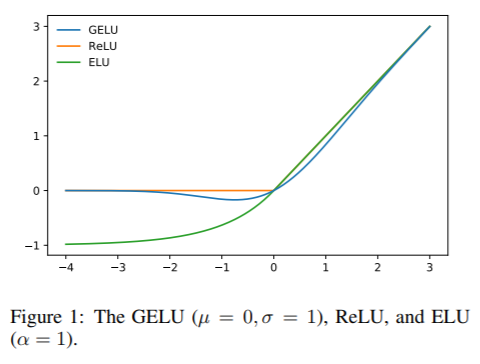

\begin{equation}
\text{FFN}(x) = \frac{x}{2} \left[ 1 + tanh\left(\sqrt{\frac{2}{\pi}} ( x + 0.044715x^3) \right) \right]
\end{equation}

In [43]:
lin_transf_exp = nn.Linear(512, 2048)
lin_transf_dim = nn.Linear(2048, 512)

def feed_forward(tensor):
    # Pass input through a linear transformation, possibly Q, K, V again
    lin_tensor = lin_transf_exp(tensor)
    
    # Input tensor passed through a GELU activation function (inner layer has dimension 2048)
    # This is applied to every position independently
    g = nn.GELU()
    gelu_tensor = g(lin_tensor) # MAYBE UPDATE THIS TO MAKE YOUR OWN
    
    # Pass input through a second linear transformation, possibly Q, K, V again (dimension of 512)
    lin_tensor_out = lin_transf_dim(gelu_tensor)

    return lin_tensor_out

### Attention Model
Attention is the biggest portion of the Tranformer. This allows the model to look at Key Value pairs regardless of the position in the string, to form a likely outcome token based on that. It is the unlocking factor that allowed us to generate LLM models.

We'll try to use an updated version form the paper, Mistral 7B, a recent (2023) development in attention models that uses a sliding window mask. This model still uses scaled dot-product attention though, so it will fundamentally remain the same, we'll just have to implement the features later.

The scaled dot-product attention is one part of our multi-head attention, these both look like:
<div>
<img src="sdpa.png" width="200"/>
<img src="mha.png" width="215"/>
</div>

Here, matmul is the dot-product of Q with K, scaling is dividing by the root of the dimension $\sqrt{d_k}$, we apply a mask if there is one, then apply the softmax, then apply the dot-product of the result with V.

In [44]:
def sca_dot_prod(Q, K, V, mask=None):
    # Compute initial dot-product
    prod = torch.matmul(Q, K)

    # Scale product
    d_k = K.size(-1)
    prod_scaled = prod / torch.sqrt(torch.tensor(d_k, dtype=attention_scores.dtype, device=attention_scores.device))

    # Add/Apply mask (optional)
    if mask:
        prod_scaled = prod_scaled + mask

    # Apply Softmax
    soft_prod = softmax(prod_scaled)

    # Compute final dot-product
    output = torch.matmul(soft_prod, V)

    return output

In [75]:
def multi_attention(tensor, h=8, mask=None):
    # Define model size, this will eventually be a global variable of a class
    d_model = 512
    
    # Check that inputted head value produces a valid distribution of the model
    assert d_model % h == 0, "model and head size is indivisible"
    
    # Get head separation
    d_k = d_model // h

    # Define attention projection matrices
    W_q = nn.linear(d_model, d_k * h, bias=False)
    W_k = nn.linear(d_model, d_k * h, bias=False)
    W_v = nn.linear(d_model, d_k * h, bias=False)

    # Define final projection to concatenate heads together
    W_f = nn.linear(d_k * h, d_model, bias=False)

    # Get parameters of the tensor
    batch_size, seq_length, d_model = x.shape

    # Project Q, K, and V
    Q = W_q(tensor)
    K = W_k(tensor)
    V = W_v(tensor)

    # Reshape the heads to include a new shape of the heads separate with the dimension
    Q = Q.view(batch_size, seq_length, h, d_k).transpose(1, 2) # transpose step swaps sequence length with head count
    K = K.view(batch_size, seq_length, h, d_k).transpose(1, 2)
    V = V.view(batch_size, seq_length, h, d_k).transpose(1, 2)

    # Apply scaled dot-product attention
    attention_out = sca_dot_prod(Q, K, V, mask)

    # Concatentate all the heads together and apply final projection
    attention_out = attention_out.transpose(1, 2).contiguous()
    attention_out = attention_out.view(batch_size, seq_length, d_model)
    result = W_f(attention_out)

    return result

### Outputs
This step is the last out of our entire model, we just need to figure out how we'll transform our output to be sent into the Transformer model. The paper says that they use learned embeddings to convert to tokens, and they also use a learned linear-transformation and softmax function to convert the decoder to predict next-token probabilities.

Following this, we will create an actual funciton to convert input/outputs to model-ready formats.

But first we need a decoder, this will take the output probabilities and convert them to a target string.

In [68]:
def out_prob(tensor):
    # The input to this will be directly after the final add&norm
    W_q = nn.Linear(tensor.shape[2], 512, bias=False)
    W_k = nn.Linear(tensor.shape[2], 512, bias=False)
    W_v = nn.Linear(tensor.shape[2], 512, bias=False)

    # Compute attention scores for Softmax input QK^T/sqrt(d)
    attention_scores = torch.bmm(Q, K.transpose(1, 2))
    d_k = K.size(-1)
    scaled_attention_scores = attention_scores / torch.sqrt(torch.tensor(d_k, dtype=attention_scores.dtype, device=attention_scores.device))

    # Apply softmax
    soft_out = softmax(scaled_attention_scores)

    # Get most probable token
    pred_token = torch.argmax(soft_out).item()

    # Return token and probabilities
    return pred_token, soft_out

## Constructing the Transformer Class
Now that we have the code pretty much setup for everything, we'll want to make a class out of it to make it look nice and be easier to use. This way we'll also be able to modify some of the steps within to change how the mask is applied and other elements.

### Overall Structure
To begin with, we'll need to familiarise ourselves with what input is being sent where, and which function relies on some pre-encoding that's not already present in our program.

#### Encoder Pipeline

First:
Our input sentence is provided to the token embedding, this will return the tokens, the last hidden state, and the pooler output. We will use the last hidden state and add our positional encoding to the last hidden state. This sum is then provided to our softmax for the probabilities.

Second:
With our initial probabilities, we then provide this to our multi-headed attention mechanism, which will run through and provide us with our modified tensor. We then take our initial probabilities and sum with the result of the multi-headed attention and normalise it.

Third:
We then provide this new normalised tensor to our feed-forward network (this will expand the domain, introduce non-linearity, and then scale back down). The initial tensor and the result of our feed-forward network are then provided to the add and normalise.

Fourth:
Now the keys and values are taken from this result and the queries come from the previous decoder layer. We then add the decoder input and the result from the attention layer and normalise.

Fifth:
Once again we provide this to the feed forward network, as well as sum the result and the initial input from step four and normalise.

Sixth:
We linearise the result, then provide this to softmax to get the output probabilities. Then we return the argmax to greedily find the most probable token. And finally we check for which token that is in our pre-learned index table.

#### Decoder Pipeline
First:
We take the outputs and provide them to token embedding then we encode them starting from i = 1 instead of 0, shifting the positional encoding right. 

Second:
We then feed this to a masked multi-head attention, the result of this is then summed with its input and normalise. The queries of this are then sent to the multi-head attention with the Key-Value pairs from the encoder pipeline. We also send the output of the add&norm to the next add&norm after the combined multi-head attention.

It was here I realised that we need to change the positional encoding because our model can't know details about the prepared sentence before it has actually been made.

In [85]:
def sca_dot_prod(self, Q, K, V, mask=None, dropout=None):
    # Compute initial dot-product
    prod = torch.matmul(Q, K.transpose(-2, -1))

    # Scale product
    d_k = Q.size(-1) # K and Q have the same size, just safety for the transpose we did earlier
    prod_scaled = prod / m.sqrt(d_k)

    # Add/Apply mask (optional)
    if mask:
        prod_scaled = prod_scaled.masked_fill(mask == 0, -1e9)

    # Apply Softmax
    soft_prod = nn.functional.softmax(prod_scaled, dim=-1)

    # Apply dropout
    if dropout:
        soft_prod = dropout(soft_prod)

    # Compute final dot-product
    output = torch.matmul(soft_prod, V)

    return output, soft_prod

In [87]:
class Layer_Attention:
    
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0, "model and head size is indivisible"
        self.d_k = d_model // h
        self.h = h
        self.W_q = nn.Linear(self.d_model, self.d_k * self.h, bias=None)
        self.W_k = nn.Linear(self.d_model, self.d_k * self.h, bias=False)
        self.W_v = nn.Linear(self.d_model, self.d_k * self.h, bias=False)
        self.attention = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, Q, K, V, mask=None):
        # Prep mask if it exists
        if mask:
            mask = mask.unsqueeze(1)

        # Get batch size
        batch_size = Q.size(0)
        
        # Reshape the heads to include a new shape of the heads separate with the dimension
        Q = Q.view(batch_size, -1, self.h, self.d_k).transpose(1, 2) # transpose step swaps sequence length with head count
        K = K.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
    
        # Apply scaled dot-product attention
        x, self.attention = sca_dot_prod(Q, K, V, mask, dropout=self.dropout)
    
        # Concatentate all the heads together and apply final projection
        x = x.transpose(1, 2).contiguous()
        x = x.view(batch_size, -1, self.h * self.d_k)

        # Remove unwanted variables to prevent storage blowing up
        del Q
        del K
        del V

        # Return result
        return self.linears[-1](x)

In [88]:
class Layer_Feed:

    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.w_init = nn.Linear(d_model, d_ff)
        self.w_fin = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        lin_tensor = w_init(x)
        g = nn.GELU()
        gelu_tensor = g(lin_tensor)
        return self.w_fin(gelu_tensor)

In [83]:
class Positional_Encoding:

    def __init__(self, dropout, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Encode positions
        PE = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1) # Adds an extra dim to make it (max_len, 1) shape, position becomes a column vec
        div = torch.exp(torch.arange(0, d_model, 2) * -(m.log(10000.0) / d_model))
        PE[:, 0::2] = torch.sin(position * div)
        PE[:, 1::2] = torch.cos(position * div)
        PE = unsqueeze(0)
        self.register_buffer("pe", PE) # This is a function to create the weight and biases

    def forward(self, x):
        x = x + self.PE[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [90]:
# Cloning function
def clone(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [91]:
# Normalisation class
class Layer_Norm:
    
    def __init__(self, size, eps=1e-6): # Epsilon for avoiding division by 0
        super().__init__()
        self.a = nn.Parameter(torch.ones(size))
        self.b = nn.Parameter(torch.zeros(size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a * (x - mean) / ( std + self.eps ) + self.b

In [94]:
# Sublayer class - Defined very nicely in the paper, this will employ the residual connection
class Sublayer:

    def __init__(self, size, dropout):
        super().__init__()
        self.norm = Layer_Norm(size)
        self.dropout = nn.dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [95]:
class Layer_Encoder:

    def __init__(self, d_model, attention, ff, dropout=0.1):
        super().__init__()
        self.attention = attention
        self.ff = ff

        # There are 2 sublayer elements, we want to be able to use this in the decoder as well so we'll make it iterative
        self.sublayer = clone(Sublayer(d_model, dropout), 2)

        self.d_model = d_model

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.attention(x, x, x, mask))
        return self.sublayer[1](x, self.ff)

In [96]:
class Encoder:

    def __init__(self, modules, N):
        super().__init()
        self.layers = clone(modules, N)
        self.norm = Layer_Norm(modules.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [99]:
# Decoder_Layer will also be very similar to Layer_Encoder except theres 3 sublayers, and we have the target and source text
class Layer_Decoder:

    def __init__(self, d_model, self_attention, src_attention, ff, dropout):
        super().__init__()
        self.d_model = d_model
        self.self_attention = self_attention
        self.src_attention = src_attention
        self.ff = ff

        # There are 2 sublayer elements, we want to be able to use this in the decoder as well so we'll make it iterative
        self.sublayer = clone(Sublayer(d_model, dropout), 3)

        self.d_model = d_model

    def forward(self, x, memory, src_mask, target_mask):
        x = self.sublayer[0](x, lambda x: self.self_attention(x, x, x, target_mask))
        x = self.sublayer[1](x, lambda x: self.source_attention(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.ff)

In [97]:
# Decoder is pretty much the same as encoder but with the source text and target text
class Decoder:

    def __init__(self, modules, N):
        super().__init()
        self.layers = clone(modules, N)
        self.norm = Layer_Norm(modules.size)

    def forward(self, x, memory, src, target):
        for layer in self.layers:
            x = layer(x, memory, src, target)
        return self.norm(x)

In [103]:
class Embeddings:

    def __init__(self, d_model, target_sentence, model_name="bert-base-uncased"):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.d_model = d_model
        self.linear = nn.Linear(768, d_model)  # We will need to modify the 768, this is a terrible solution, but just ignore it

    def forward(self, sentence):
        tokens = self.tokenizer(sentence, return_tensors='pt')

        with torch.no_grad():
            outputs = self.model(**tokens)
        
        lhs = outputs.last_hidden_state

        # Apply Linear Transformation and Scale by sqrt(d_model)
        return self.linear(lhs) * math.sqrt(self.d_model)

In [104]:
class Layer_Prob:

    def __init__(self, d_model, res_sent):
        super().__init__()
        self.w = nn.Linear(d_model, res_sent)

    def forward(self, x):
        return nn.functional.log_softmax(self.w(x), dim=-1)

In [106]:
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import transformers
import math as m
import torch
import copy

def make_model(sentence, result_sentence, tokenizer, model, N, d_model=512, h=8, d_ff=2048, dropout=0.1, mask=None):
    """
    This function is a helped for creating the model.
    """
    c = copy.deepcopy
    attention = Layer_Attention(d_model, h)
    ff = Layer_Feed(d_model, d_ff, dropout)
    pe = Positional_Encoding(dropout, d_model)
    
    # Model
    model = EncoderDecoder(
        Encoder(Layer_Encoder(d_model, c(attention), c(ff), dropout), N), # E&D layers will take the model, the prev layers,
        Decoder(Layer_Decoder(d_model, c(attention), c(attention), c(ff), dropout), N), # the sublayer count, and dropout
        nn.Sequential(Embeddings(d_model, sentence), c(pe)), # Sequential creates a small model and passes inputs in sequentially
        nn.Sequential(Embeddings(d_model, result_sentence), c(pe)),
        Layer_Prob(d_model, result_sentence)
    )

## Notes from trying to make a class out of the Transformer
- The structure of the functions was not enough initially, so we've had to modify the structure and output of them significantly to make them compatible
    - The thing to learn from this is that we are using classes to just modify an input, so we're passing it through a prebuilt formula
- There's several modifications to how we modify transposes and apply masks that I had to search up, but they definitely work now
- We've also now modified the embeddings a little to return the softmax output for the scaled embeddings
- We've introduced a variable architecture for the encoder and decoder so that we can scale up if we want in the future

In [107]:
# Test the model!
# Will get to this later